# Assignment 4 Survival Analysis
Applications for Kaplan-Meier survivall curves, Cox Proportional Hazards regression and Randon Survival Forests(RSF)

Using clinical dataset from The Cancer Imaging Archive, which contains survival time, event indicators and covariates (age, treatment type and tumor stage).

In [ ]:
# Load libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

# Preprocessing
from sksurv.util import Surv

# Kaplan-Meier 
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test

# Cox
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

# Random Survival Forest
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


In [ ]:
# Load data
cancersurviv = df = pd.read_excel(r'c:\Users\arjun\binf5507\BINF5507\RADCURE_Clinical_v04_20241219.xlsx')

cancersurviv.head()
cancersurviv.info()
print(cancersurviv.columns)

# Preprocessing

# Handle missing values

# Calculaate how many missing values for each column
missing = cancersurviv.isnull().mean().sort_values(ascending=False)
print("Missing Values Percentage:")
print((missing * 100).round(2).astype(str) + "%")

# Censor columns have > 50% missinng values Regional, Date Regional, Local, Date Local, Distant, Date Distant, 2nd Ca, Date 2nd Ca, Cause of Death, Date of Death

# Drop HPV column (48.68 % missing) and RadCure Challenge Column (redundant)
cancersurviv = cancersurviv.drop(columns=["HPV", "RADCURE-challenge"])

# Impute numeric columns with mean
cancersurviv = cancersurviv.fillna(cancersurviv.mean(numeric_only=True))

# Impute categorical columns with mode
categorical_data = ['ECOG PS', 'Subsite', 'T', 'N', 'M ', 'Stage']
for col in categorical_data:
    mode_val = cancersurviv[col].mode(dropna=True)[0]
    cancersurviv[col].fillna(mode_val, inplace=True)
    
# Create time and event columns for survival analysis
cancersurviv['time'] = (cancersurviv[['Date of Death', 'Last FU']].min(axis=1) - cancersurviv['RT Start']).dt.days
cancersurviv['event'] = (cancersurviv['Status'] == 'Dead').astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         3346 non-null   object        
 1   Age                3346 non-null   float64       
 2   Sex                3346 non-null   object        
 3   ECOG PS            3345 non-null   object        
 4   Smoking PY         3341 non-null   object        
 5   Smoking Status     3346 non-null   object        
 6   Ds Site            3346 non-null   object        
 7   Subsite            2972 non-null   object        
 8   T                  3334 non-null   object        
 9   N                  3333 non-null   object        
 10  M                  3332 non-null   object        
 11  Stage              3319 non-null   object        
 12  Path               3346 non-null   object        
 13  HPV                1717 non-null   object        
 14  Tx Modal

C:\Users\arjun\AppData\Local\Temp\ipykernel_2812\2587219205.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cancersurviv[col].fillna(mode_val, inplace=True)


### Kaplan-Meier Analysis 
Kaplan-Meier Survival Analysis performed for the Tx Modality column and Smoking Status column. 

Tx Modality is the treatment type i.e. how surgery, radiation and chemotherapy are combined for the specific patient. This includes the categories 'RT alone' (radiation therapy), 'ChemoRT' (chemotherapy and radiation therapy), 'RT + EGFRI' (radiation therapy and epidermal growth factor inhibitors) along with others. 


Smoking status is defined as 'current', 'ex-smoker' and 'non-smoker' with some unknown rows. 

Log-rank tests are performed to compare survival differences between the groups. 

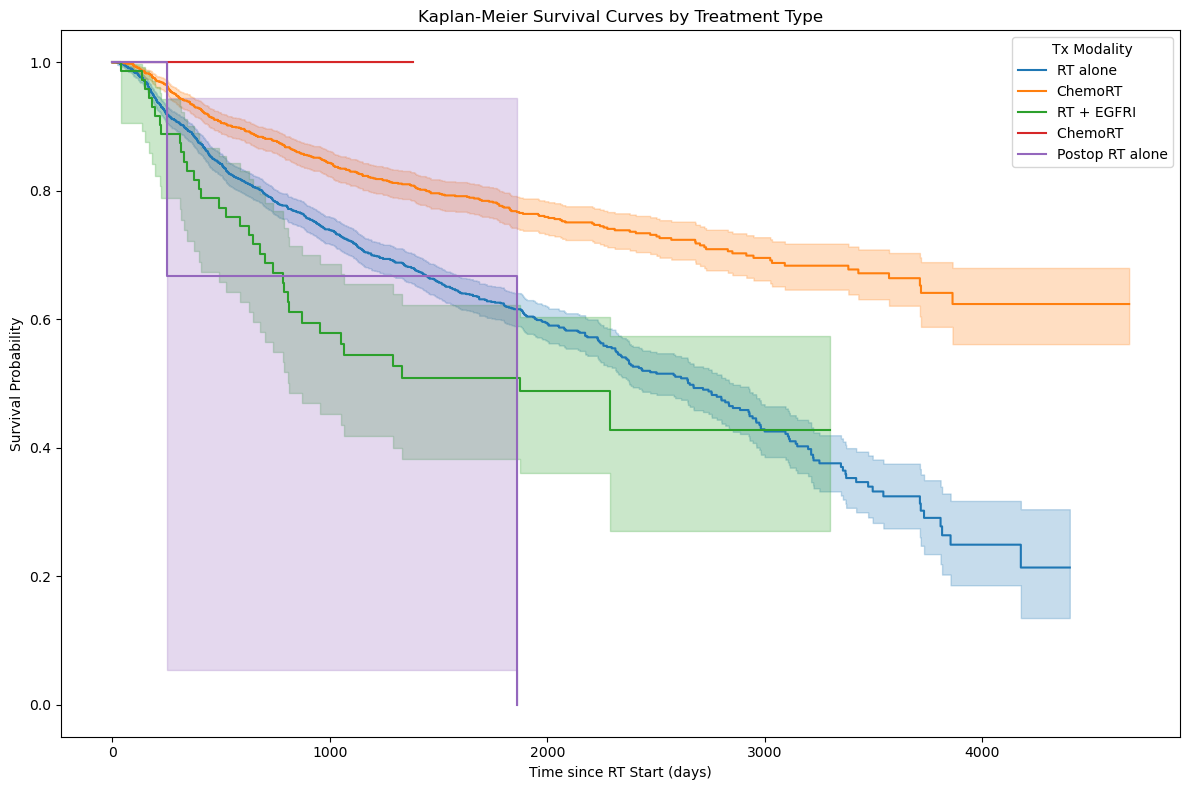

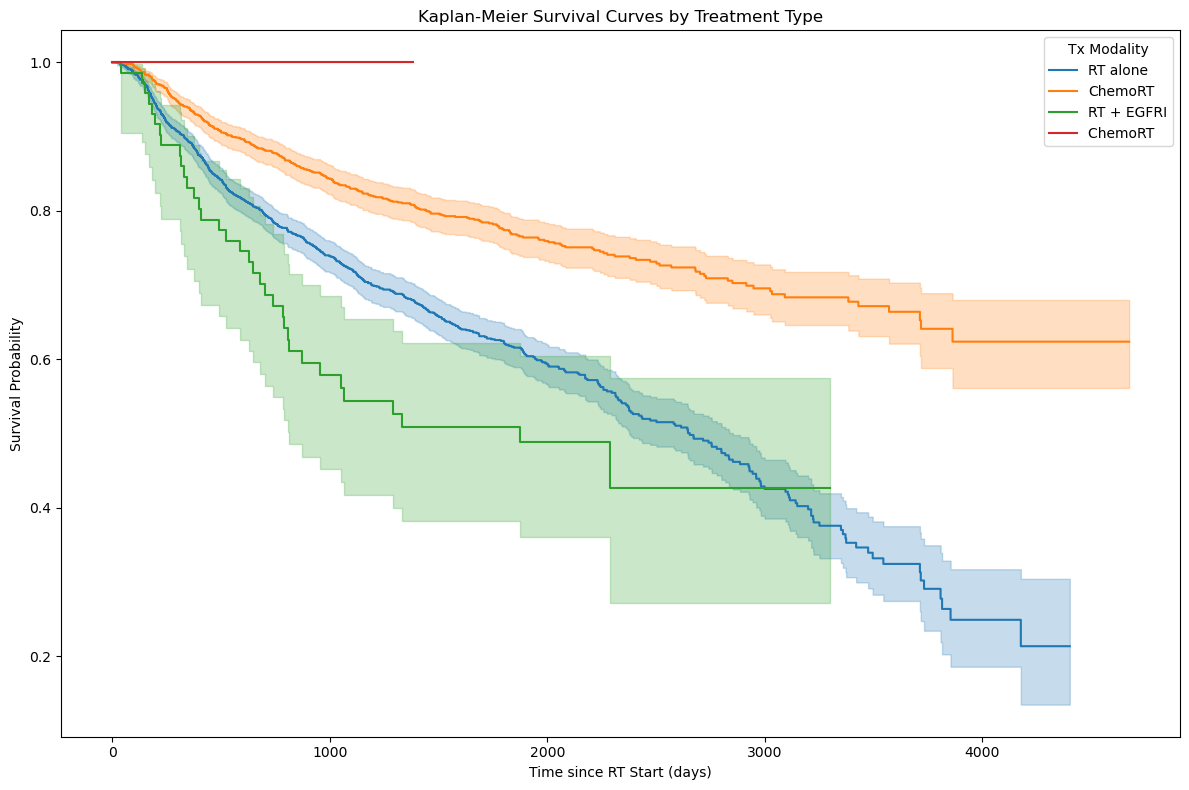

In [124]:
# Survival Curves For Treatment Type

# Drop any remaining missing values for required columns
treatment_type = cancersurviv
treatment_type = cancersurviv.dropna(subset=['Tx Modality', 'time', 'event'])

# Get a list of unique treatment types
modalities = treatment_type['Tx Modality'].unique()

# Initialize the figure
plt.figure(figsize=(12, 8))
kmf_treatment = KaplanMeierFitter()

# Loop through each treatment type and plot the survival curves
for modality in modalities:
    #Filter for the current treatment type
    mask = treatment_type["Tx Modality"] == modality
    # Fit the Kaplan-Meier estimator
    kmf_treatment.fit(durations=treatment_type[mask]['time'],
                      event_observed=treatment_type[mask]['event'], label=modality)
    # Plot the survival function
    kmf_treatment.plot_survival_function()

# Plot the Kaplan-Meier curve
plt.title('Kaplan-Meier Survival Curves by Treatment Type')
plt.xlabel('Time since RT Start (days)')
plt.ylabel('Survival Probability')
plt.legend(title='Tx Modality')
plt.tight_layout()
plt.show()

# Cleaned figure with low count treatment types removed
# Filter out treatment types with low counts
filtered_df = treatment_type.copy()
filtered_df = filtered_df[filtered_df['Tx Modality'] != 'Postop RT alone']

modalities = filtered_df['Tx Modality'].unique()
# Initialize the figure
plt.figure(figsize=(12, 8))
kmf_treatment_clean = KaplanMeierFitter()

# Loop through each treatment type and plot the survival curves
for modality in modalities:
    #Filter for the current treatment type
    mask = filtered_df["Tx Modality"] == modality
    # Fit the Kaplan-Meier estimator
    kmf_treatment.fit(durations=filtered_df[mask]['time'],
                      event_observed=filtered_df[mask]['event'], label=modality)
    # Plot the survival function
    kmf_treatment.plot_survival_function()

# Plot the Kaplan-Meier curve
plt.title('Kaplan-Meier Survival Curves by Treatment Type')
plt.xlabel('Time since RT Start (days)')
plt.ylabel('Survival Probability')
plt.legend(title='Tx Modality')
plt.tight_layout()
plt.show()


In [123]:
# Log-rank test -> between RT alone and ChemoRT
group1 = treatment_type[treatment_type['Tx Modality'] == 'RT alone']
group2 = treatment_type[treatment_type['Tx Modality'] == 'ChemoRT']

results = logrank_test(
    durations_A=group1['time'],
    durations_B=group2['time'],
    event_observed_A=group1['event'],
    event_observed_B=group2['event']
)

print(f"Log-rank test p-value between RT alone and ChemoRT: {results.p_value:.4f}")

# Multivariate log-rank test -> between RT alone, ChemoRT & RT + EGFRI
results_multivariate = multivariate_logrank_test(
    treatment_type['time'],
    treatment_type['Tx Modality'],
    event_observed=treatment_type['event']
)
results_multivariate.print_summary()


Log-rank test p-value between RT alone and ChemoRT: 0.0000


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         132.66 <0.005     89.62

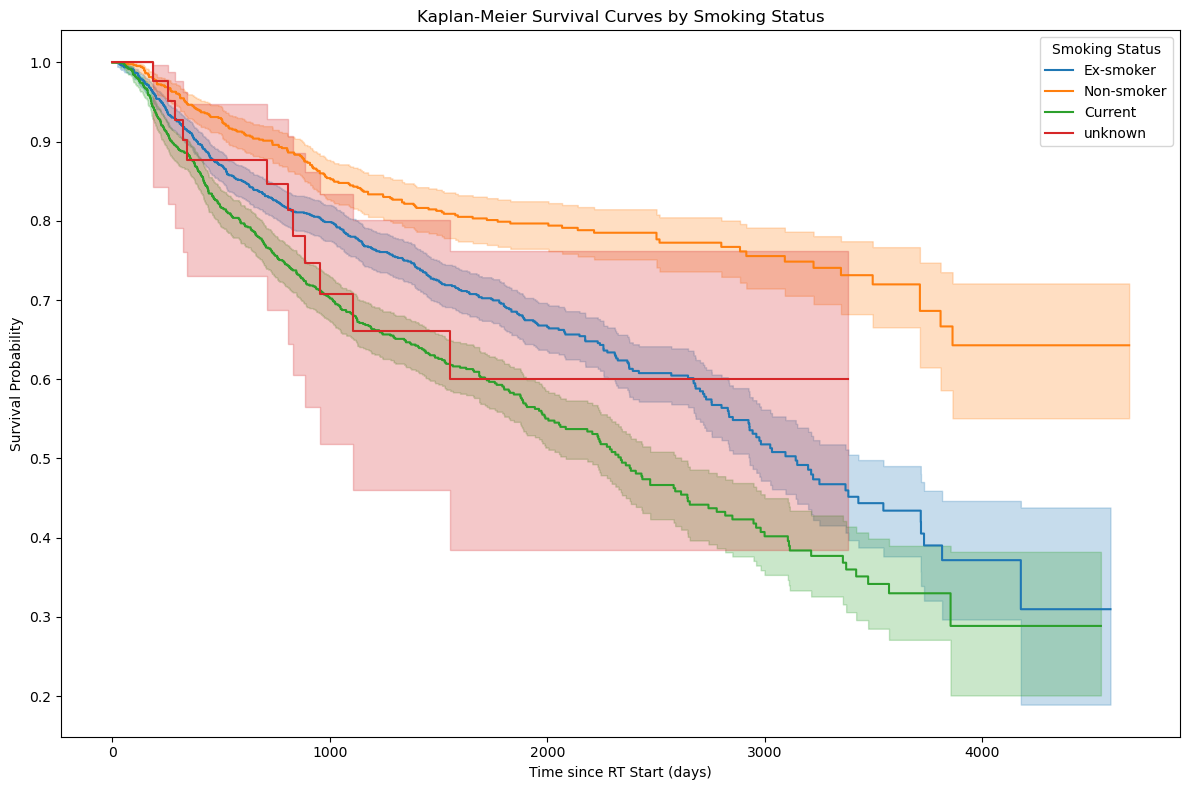

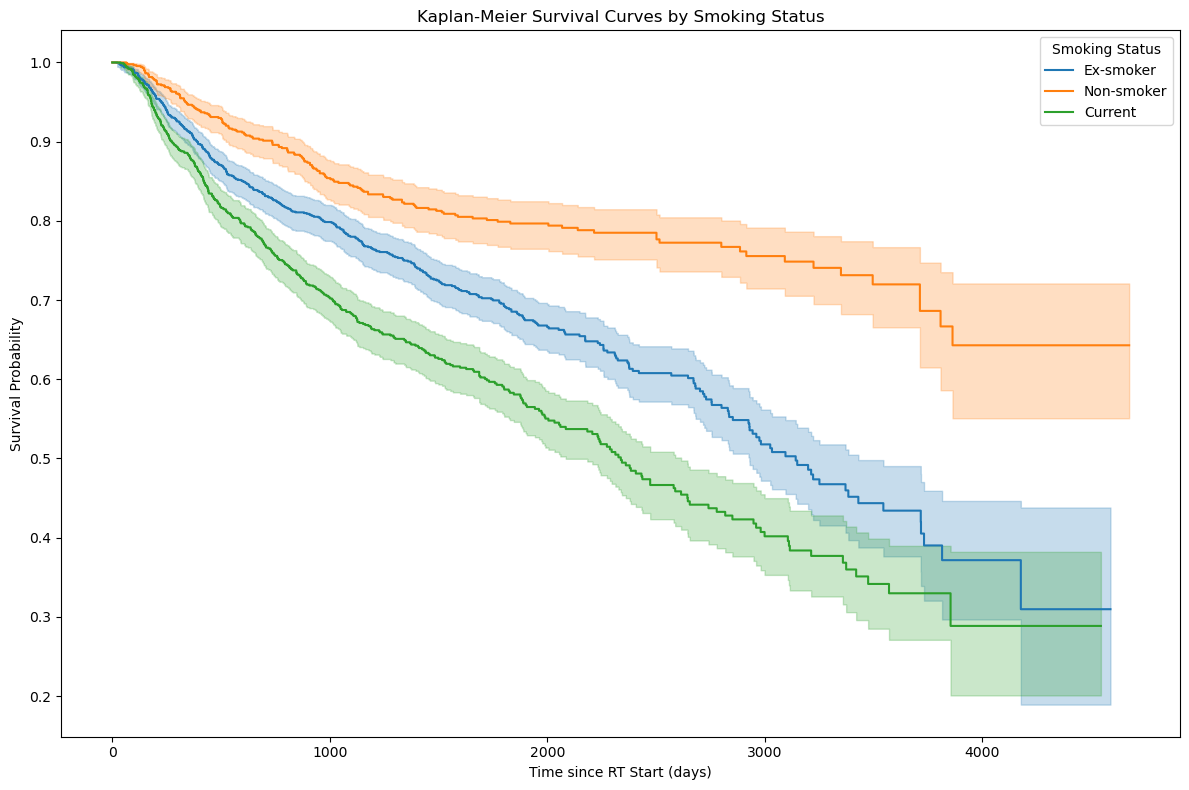

In [127]:
# Survival Curves for Smoking Status

# Drop any remaining missing values for required columns
smoking_status = cancersurviv
smoking_status = cancersurviv.dropna(subset=['Smoking Status', 'time', 'event'])
# Get a list of unique treatment types
statuses = smoking_status['Smoking Status'].unique()

# Initialize the figure
plt.figure(figsize=(12, 8))
kmf_smoking = KaplanMeierFitter()

# Loop through each treatment type and plot the survival curves
for status in statuses:
    #Filter for the current treatment type
    filter = smoking_status["Smoking Status"] == status
    # Fit the Kaplan-Meier estimator
    kmf_smoking.fit(durations=smoking_status[filter]['time'],
                      event_observed=smoking_status[filter]['event'], label=status)
    # Plot the survival function
    kmf_smoking.plot_survival_function()

# Plot the Kaplan-Meier curve
plt.title('Kaplan-Meier Survival Curves by Smoking Status')
plt.xlabel('Time since RT Start (days)')
plt.ylabel('Survival Probability')
plt.legend(title='Smoking Status')
plt.tight_layout()
plt.show()

# Remove Smoking Status Unknown for a cleaner curve
smoking_status_clean = smoking_status.copy()
smoking_status_clean = smoking_status_clean[smoking_status_clean['Smoking Status'] != 'unknown']

statuses = smoking_status_clean['Smoking Status'].unique()

# Initialize the figure
plt.figure(figsize=(12, 8))
kmf_smoking_clean = KaplanMeierFitter()

# Loop through each treatment type and plot the survival curves
for status in statuses:
    #Filter for the current treatment type
    filter = smoking_status_clean["Smoking Status"] == status
    # Fit the Kaplan-Meier estimator
    kmf_smoking_clean.fit(durations=smoking_status_clean[filter]['time'],
                      event_observed=smoking_status_clean[filter]['event'], label=status)
    # Plot the survival function
    kmf_smoking_clean.plot_survival_function()

# Plot the Kaplan-Meier curve
plt.title('Kaplan-Meier Survival Curves by Smoking Status')
plt.xlabel('Time since RT Start (days)')
plt.ylabel('Survival Probability')
plt.legend(title='Smoking Status')
plt.tight_layout()
plt.show()


In [128]:
# Log-rank test for Smoking Status

smoke_group1 = smoking_status[smoking_status['Smoking Status'] == 'Non-smoker']
smoke_group2 = smoking_status[smoking_status['Smoking Status'] == 'Current']

results2 = logrank_test(
    durations_A=smoke_group1['time'],
    durations_B=smoke_group2['time'],
    event_observed_A=smoke_group1['event'],
    event_observed_B=smoke_group2['event']
)

print(f"Log-rank test p-value between Non-Smoke and Current Smoker: {results2.p_value:.4f}")

# Multivariate log-rank test
results_multivariate = multivariate_logrank_test(
    smoking_status['time'],
    smoking_status['Smoking Status'],
    event_observed=smoking_status['event']
)
results_multivariate.print_summary()


Log-rank test p-value between Non-Smoke and Current Smoker: 0.0000


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         128.10 <0.005     89.22

### Cox Proportional Hazards Regression
Cox Proportional Hazards Regression is performed using the covariates Age, Sex, Tx Modality, Smoking Status and Ds Site. 

Ds Site is the primary cancer site and 'Oropharynx', 'Larynx' and 'Nasopharynx' are the highest frequency categories.


<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7723.21
         time fit was run = 2025-07-15 01:54:32 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
Age                           0.04      1.04      0.00            0.03            0.04                1.03                1.04
Sex_Male                      0.01      1.01      0.08           -0.14            0.17                0.87                1.18
Tx Modality_ChemoRT         -11.35      0.00    808.81        -1596.58         1573.88                0.00                 inf
Tx Modality_Postop RT alone   1.34      3.84      1.00           -0.62            3.31                0.54               27.51
Tx Modality_RT + EGFRI        0.51      1.66      0.19            0.14            0.87                1.15                2.39
Tx Modality_RT alone          0.32      1.37      0.08            0.16            0.48                1.17                1.61
Smoking Status_Ex-smoker     -0.48      0.62      0.07           -0.62           -0.35                0.54                0.71
Smoking Status_Non-smoker    -0.90      0.41      0.09           -1.09           -0.72                0.34                0.49
Smoking Status_unknown       -0.41      0.66      0.34           -1.08            0.26                0.34                1.30
Ds Site_Hypopharynx          -0.74      0.48      0.31           -1.35           -0.13                0.26                0.87
Ds Site_Lacrimal gland      -11.51      0.00   1586.74        -3121.47         3098.44                0.00                 inf
Ds Site_Larynx               -1.68      0.19      0.30           -2.27           -1.09                0.10                0.34
Ds Site_Lip & Oral Cavity    -0.85      0.43      0.32           -1.48           -0.22                0.23                0.80
Ds Site_Nasal Cavity         -2.24      0.11      0.65           -3.51           -0.97                0.03                0.38
Ds Site_Nasopharynx          -1.73      0.18      0.32           -2.36           -1.10                0.09                0.33
Ds Site_Orbit               -14.42      0.00   1088.19        -2147.25         2118.40                0.00                 inf
Ds Site_Oropharynx           -1.40      0.25      0.30           -1.98           -0.82                0.14                0.44
Ds Site_Other                 0.07      1.07      0.77           -1.44            1.57                0.24                4.83
Ds Site_Paraganglioma        -1.73      0.18      1.08           -3.85            0.39                0.02                1.47
Ds Site_Paranasal Sinus      -0.72      0.49      0.42           -1.55            0.11                0.21                1.11
Ds Site_Salivary Glands      -1.76      0.17      1.04           -3.81            0.28                0.02                1.33
Ds Site_Sarcoma              -0.59      0.55      0.50           -1.58            0.39                0.21                1.48
Ds Site_Skin                 -0.96      0.38      0.41           -1.75           -0.16                0.17                0.85
Ds Site_Unknown              -1.44      0.24      0.33           -2.08           -0.80                0.13                0.45
Ds Site_benign tumor         -1.56      0.21      1.45           -4.40            1.28                0.01                3.58
Ds Site_esophagus            -0.60      0.55      0.43           -1.44            0.25                0.24                1.28
Ds Site_nasal cavity         -1.40      0.25      0.43           -2.24           -

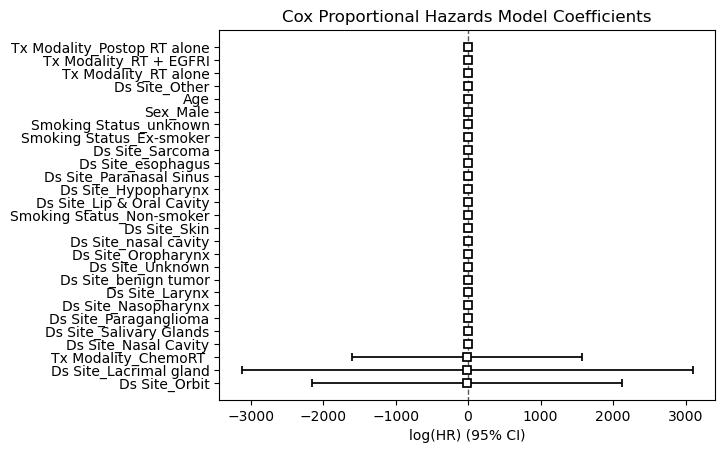

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
         test_name = proportional_hazard_test

---
                                  test_statistic    p  -log2(p)
Age                         km              7.78 0.01      7.56
                            rank            7.78 0.01      7.57
Ds Site_Hypopharynx         km              0.00 0.96      0.06
                            rank            0.12 0.72      0.47
Ds Site_Lacrimal gland      km              0.00 1.00      0.00
                            rank            0.00 1.00      0.00
Ds Site_Larynx              km              0.16 0.69      0.53
                            rank            0.04 0.84      0.25
Ds Site_Lip & Oral Cavity   km              0.15 0.70      0.51
                            rank            0.64 0.42      1.24
Ds Site_Nasal Cavity        km              0.51 0.48      1.07
                            rank            0.95 0.33      1.60
Ds Site_Nasopharynx         km              0.79 0.37      1.42
                            rank            0.42 0.52      0.95
Ds Site_Orbit               km              0.00 1.00      0.00
                            rank            0.00 1.00      0.00
Ds Site_Oropharynx          km              0.21 0.65      0.63
                            rank            0.56 0.46      1.14
Ds Site_Other               km              0.56 0.45      1.14
                            rank            0.78 0.38      1.41
Ds Site_Paraganglioma       km              0.00 0.96      0.05
                            rank            0.00 1.00      0.00
Ds Site_Paranasal Sinus     km              2.80 0.09      3.41
                            rank            3.54 0.06      4.06
Ds Site_Salivary Glands     km              0.10 0.75      0.41
                            rank            0.19 0.66      0.59
Ds Site_Sarcoma             km              0.23 0.63      0.67
                            rank            0.45 0.50      0.99
Ds Site_Skin                km              0.00 0.97      0.05
                            rank            0.00 0.98      0.02
Ds Site_Unknown             km              0.23 0.63      0.66
                            rank            0.02 0.89      0.18
Ds Site_benign tumor        km              0.61 0.43      1.20
                            rank            0.53 0.47      1.10
Ds Site_esophagus           km              2.83 0.09      3.44
                            rank            3.94 0.05      4.40
Ds Site_nasal cavity        km              0.01 0.91      0.13
                            rank            0.06 0.81      0.31
Sex_Male                    km              1.56 0.21      2.24
                            rank            1.91 0.17      2.59
Smoking Status_Ex-smoker    km              0.41 0.52      0.94
                            rank            0.12 0.73      0.45
Smoking Status_Non-smoker   km              0.76 0.38      1.39
                            rank            0.35 0.56      0.85
Smoking Status_unknown      km              0.66 0.42      1.26
                            rank            0.82 0.37      1.45
Tx Modality_ChemoRT         km              0.00 1.00      0.00
                            rank            0.00 1.00      0.00
Tx Modality_Postop RT alone km              0.00 0.99      0.02
                            rank            0.00 0.98      0.03
Tx Modality_RT + EGFRI      km              0.10 0.76      0.40
                            rank            0.16 0.69      0.55
Tx Modality_RT alone        km              2.03 0.15      2.70
                            rank            0.57 0.45      1.15



1. Variable 'Age' failed the non-proportional test: p-value is 0.0053.

   Advice 1: the functional form of the variable 'Age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age' using pd.cut, and then specify it in `strata=['Age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Ds Site_esophagus' failed the non-proportional test: p-value is 0.0472.

   Advice: with so few unique values (only 2), you can include `strata=['Ds Site_esophagus', ...]`
in the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifel

[]

In [130]:
# Cox regression analysis
# Covariates: Age, Sex, Tx Modality, Smoking Status & Ds Site
cox_df = cancersurviv[['time', 'event', 'Age','Sex', 'Tx Modality', 'Smoking Status', 'Ds Site']].dropna()

# One hot encode categorical variables
cox_df = pd.get_dummies(cox_df, columns=['Sex', 'Tx Modality', 'Smoking Status', 'Ds Site'], drop_first=True)

# Fit the Cox proportional hazards model
cph = CoxPHFitter()  
cph.fit(cox_df, duration_col='time', event_col='event')

cph.print_summary()
cph.concordance_index_

# Plot the coefficients
cph.plot()
plt.title('Cox Proportional Hazards Model Coefficients')
plt.show()

# Validate proportional hazards assumption
cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=False)


### Proportional Hazards Assumption
The Cox Proportional Hazards Regression Model assumes that all individuals have the same hazard function.

With the covariates Age, Sex, Tx Modality, Smoking Status and Ds Site, age and Ds Site_Esophagus fail the non-proportional test. 

Ds Site Esophagus is likely due to the lack of unique values, while age is the more challenging column to handle. 

In [131]:
# Handling age -> create an interaction with time
cox_df['age_log_time'] = cox_df['Age'] * np.log(cox_df['time'])
cox_df = cox_df.drop(columns=['Age'])  # Drop original Age column to avoid multicollinearity

# Fit the Cox proportional hazards model again age_log_time interaction
cph = CoxPHFitter() 
cph.fit(cox_df, duration_col='time', event_col='event')
cph.print_summary()
cph.concordance_index_

cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=False)

<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7638.52
         time fit was run = 2025-07-15 01:55:09 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
Sex_Male                      0.00      1.00      0.08           -0.15            0.16                0.86                1.17
Tx Modality_ChemoRT         -11.11      0.00    836.54        -1650.71         1628.49                0.00                 inf
Tx Modality_Postop RT alone   1.51      4.55      1.00           -0.45            3.48                0.64               32.57
Tx Modality_RT + EGFRI        1.46      4.31      0.18            1.10            1.82                3.01                6.18
Tx Modality_RT alone          0.90      2.46      0.08            0.75            1.05                2.11                2.86
Smoking Status_Ex-smoker     -0.13      0.88      0.07           -0.27            0.00                0.77                1.00
Smoking Status_Non-smoker    -0.84      0.43      0.09           -1.03           -0.66                0.36                0.52
Smoking Status_unknown       -0.42      0.66      0.35           -1.10            0.27                0.33                1.30
Ds Site_Hypopharynx          -0.72      0.49      0.31           -1.33           -0.11                0.27                0.89
Ds Site_Lacrimal gland      -15.90      0.00   1668.18        -3285.47         3253.66                0.00                 inf
Ds Site_Larynx               -1.80      0.17      0.30           -2.39           -1.21                0.09                0.30
Ds Site_Lip & Oral Cavity    -0.86      0.42      0.32           -1.48           -0.23                0.23                0.80
Ds Site_Nasal Cavity         -2.40      0.09      0.65           -3.67           -1.13                0.03                0.32
Ds Site_Nasopharynx          -2.46      0.09      0.32           -3.09           -1.82                0.05                0.16
Ds Site_Orbit               -13.56      0.00   1131.50        -2231.25         2204.13                0.00                 inf
Ds Site_Oropharynx           -1.72      0.18      0.30           -2.30           -1.14                0.10                0.32
Ds Site_Other                -0.71      0.49      0.77           -2.22            0.79                0.11                2.21
Ds Site_Paraganglioma        -3.01      0.05      1.10           -5.15           -0.86                0.01                0.42
Ds Site_Paranasal Sinus      -1.10      0.33      0.42           -1.92           -0.27                0.15                0.76
Ds Site_Salivary Glands      -1.98      0.14      1.05           -4.03            0.07                0.02                1.07
Ds Site_Sarcoma              -1.55      0.21      0.52           -2.57           -0.54                0.08                0.59
Ds Site_Skin                 -0.48      0.62      0.40           -1.27            0.31                0.28                1.36
Ds Site_Unknown              -1.75      0.17      0.33           -2.40           -1.11                0.09                0.33
Ds Site_benign tumor         -1.44      0.24      1.45           -4.28            1.39                0.01                4.03
Ds Site_esophagus            -0.39      0.68      0.43           -1.23            0.46                0.29                1.58
Ds Site_nasal cavity         -1.97      0.14      0.43           -2.81           -1.12                0.06                0.32
age_log_time                 -0.01      0.99      0.00           -0.01           -

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
         test_name = proportional_hazard_test

---
                                  test_statistic      p  -log2(p)
Ds Site_Hypopharynx         km              0.15   0.70      0.52
                            rank            0.58   0.45      1.17
Ds Site_Lacrimal gland      km              0.00   1.00      0.00
                            rank            0.00   1.00      0.00
Ds Site_Larynx              km              0.13   0.72      0.47
                            rank            0.02   0.88      0.19
Ds Site_Lip & Oral Cavity   km              0.66   0.42      1.26
                            rank            1.32   0.25      2.00
Ds Site_Nasal Cavity        km              0.51   0.47      1.08
                            rank            0.95   0.33      1.60
Ds Site_Nasopharynx         km              2.67   0.10      3.29
                            rank            2.29   0.13      2.94
Ds Site_Orbit               km              0.00   1.00      0.00
                            rank            0.00   1.00      0.00
Ds Site_Oropharynx          km              0.38   0.54      0.89
                            rank            0.73   0.39      1.34
Ds Site_Other               km              0.90   0.34      1.55
                            rank            1.25   0.26      1.92
Ds Site_Paraganglioma       km              1.68   0.20      2.36
                            rank            1.77   0.18      2.45
Ds Site_Paranasal Sinus     km              1.43   0.23      2.11
                            rank            2.18   0.14      2.84
Ds Site_Salivary Glands     km              0.06   0.81      0.30
                            rank            0.01   0.93      0.10
Ds Site_Sarcoma             km              1.13   0.29      1.79
                            rank            0.73   0.39      1.35
Ds Site_Skin                km              1.71   0.19      2.39
                            rank            1.71   0.19      2.39
Ds Site_Unknown             km              0.42   0.52      0.95
                            rank            0.10   0.75      0.42
Ds Site_benign tumor        km              0.20   0.66      0.61
                            rank            0.15   0.70      0.51
Ds Site_esophagus           km              1.04   0.31      1.70
                            rank            1.99   0.16      2.66
Ds Site_nasal cavity        km              0.00   0.97      0.04
                            rank            0.00   0.96      0.07
Sex_Male                    km              0.09   0.77      0.38
                            rank            0.23   0.63      0.66
Smoking Status_Ex-smoker    km              4.58   0.03      4.95
                            rank            6.37   0.01      6.43
Smoking Status_Non-smoker   km              2.46   0.12      3.10
                            rank            1.53   0.22      2.21
Smoking Status_unknown      km              0.66   0.42      1.27
                            rank            1.03   0.31      1.69
Tx Modality_ChemoRT         km              0.00   1.00      0.00
                            rank            0.00   1.00      0.00
Tx Modality_Postop RT alone km              0.01   0.91      0.14
                            rank            0.01   0.91      0.14
Tx Modality_RT + EGFRI      km              7.00   0.01      6.94
                            rank            8.08 <0.005      7.80
Tx Modality_RT alone        km              5.03   0.02      5.33
                            rank            9.12 <0.005      8.62
age_log_time                km            342.18 <0.005    251.37
                            rank          375.31 <0.005    275.33



1. Variable 'Tx Modality_RT + EGFRI' failed the non-proportional test: p-value is 0.0045.

   Advice: with so few unique values (only 2), you can include `strata=['Tx Modality_RT + EGFRI',
...]` in the call in `.fit`. See documentation in link [E] below.

2. Variable 'Tx Modality_RT alone' failed the non-proportional test: p-value is 0.0025.

   Advice: with so few unique values (only 2), you can include `strata=['Tx Modality_RT alone',
...]` in the call in `.fit`. See documentation in link [E] below.

3. Variable 'Smoking Status_Ex-smoker' failed the non-proportional test: p-value is 0.0116.

   Advice: with so few unique values (only 2), you can include `strata=['Smoking Status_Ex-smoker',
...]` in the call in `.fit`. See documentation in link [E] below.

4. Variable 'age_log_time' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'age_log_time' might be incorrect. That is, there
may be non-linear terms missing. The proportional 

[]

### Validate the Proportional Hazards Assumption
Handling the age column by turning it into an interaction term does improve the model's concordance index. However, the new age_log_time column also appears to fail the test. Handling it by binning the age into categorical age groups did not help either. 

### Random Survival Forests (RSF)
RSF built with the same covariates as Cox regression for direct comparison. 

Permutation importance used to evaluate feature importance and identify the most predictive factors. 

C:\Users\arjun\AppData\Local\Temp\ipykernel_2812\2879644082.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


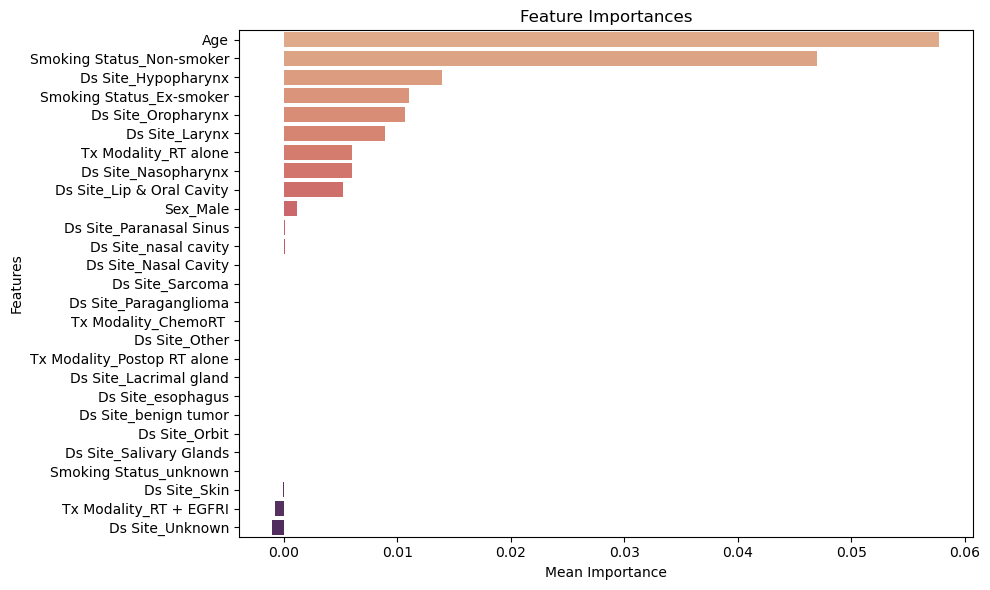

In [137]:
# Random Survival Forest

# Load the dataset and prepare the features and target variable - same features as Cox model

X = cancersurviv[['Age', 'Sex', 'Tx Modality', 'Smoking Status', 'Ds Site']]
X = X.dropna()

y = Surv.from_arrays(
    event=cancersurviv.loc[X.index, 'event'].astype(bool),
    time=cancersurviv.loc[X.index, 'time'])

# # One-hot encode categorical variables
X_cat = pd.get_dummies(X[['Sex', 'Tx Modality', 'Smoking Status', 'Ds Site']], drop_first=True)

X = pd.concat([X[['Age']], X_cat], axis=1)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Survival Forest model
rsf = RandomSurvivalForest(
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rsf.fit(X_train, y_train)

# # Variable importance analysis
result = permutation_importance(
    rsf,
    X_test,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1)

# Feature importance DataFrame
feature_importance = pd.DataFrame({
    "importances_mean": result["importances_mean"],
    "importances_std": result["importances_std"]
}, index=X.columns).sort_values(by="importances_mean", ascending=False)

# Rename the index to 'Feature' for clarity
feature_importance = feature_importance.rename_axis('Feature').reset_index()

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance,
    x='importances_mean',
    y='Feature',
    palette='flare',
    orient='h')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


### Feature Importance
The most predictive features for the RSF are age, smoking status (non-smoker) and Ds site (hypopharynx). Smoking status (ex-smoker), Ds site (oropharynx), Ds Site (Larynx), Tx Modality (RT alone), Ds site (nasopharynx), Ds site (lip & oral cavity) amd Sex (male) are also contributing features. 

Tx Modality (RT + EGFRI) appears to have a negative importance. 

### Comparison of the Concordance Indices
Finally we can compare the concordance indices of the two models.

Cox Concordance Index: 0.7478
Random Survival Forest Concordance Index: 0.6721


C:\Users\arjun\AppData\Local\Temp\ipykernel_2812\1440451533.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


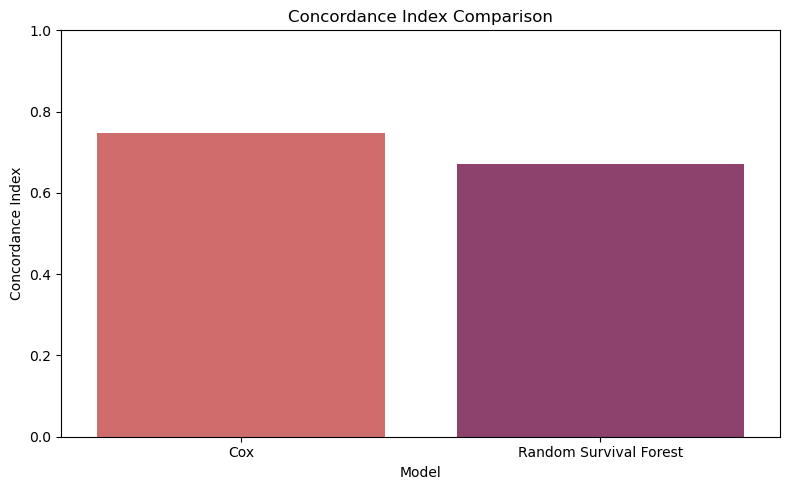

In [ ]:
# Comparison of the Concordance Index between Cox and Random Survival Forest

# Cox regression concordance index
c_index_cox = cph.concordance_index_

# Random Survival Forest concordance index
risk_scores = rsf.predict(X_test)
c_index_test = concordance_index_censored(
    event_indicator=y_test['event'], 
    event_time=y_test['time'],
    estimate=risk_scores
)[0]

print(f"Cox Concordance Index: {c_index_cox:.4f}")
print(f"Random Survival Forest Concordance Index: {c_index_test:.4f}")

# # Plot the concordance indices
plt.figure(figsize=(8, 5))
sns.barplot(
    x=['Cox', 'Random Survival Forest'],
    y=[c_index_cox, c_index_test],
    palette='flare'
)
plt.title('Concordance Index Comparison')
plt.ylabel('Concordance Index')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
